<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

# Описание задачи  

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель для супермаркета «Хлеб-Соль», которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

## Исследовательский анализ данных

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import seaborn as sns
from PIL import Image

In [17]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [20]:
print('Количество дубликатов - ', data.duplicated().sum())

Количество дубликатов -  0


- Датасет состоит из 7591 фотографии. Пропущенных значений не имеется, возраст представлен типом int, столбцец с нанованием файлов фото типом  object.   

- Средний возраст людей на фотографиях - 31, медианный - 29.  
- На фотографиях представлены люди разных возрастов от 1 года до 100. До 75% датасета состоит из фотографий людей до 41 года.

In [21]:
def boxplot_5(df, tit='Data', figs=(13, 4)):  
    
    # функция по построению  boxplot
    # на вход: df - датасет, tit  - имя Графиков,  figs - размер
    fig, axs = plt.subplots(figsize=figs)
    
    box_col = sns.boxplot(x=df, color='plum', linewidth=2.5)
    box_col = sns.stripplot(x=df, marker="o", alpha=0.05, color='blueviolet')
        
    box_col.set_title(tit, fontsize=16)
    
    box_col.grid(color = 'lightblue', linewidth = 1, linestyle=':')

In [22]:
# график плотности распределения
def kde_one(df, lab, figs=(12, 4), fontsize_1=14, loc1='upper right'):

    fig, axs = plt.subplots(figsize=figs)    

    sns.kdeplot(df, shade=True, legend=True, color='blueviolet', label=lab)
        
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    plt.title(lab, fontsize=16)
    plt.legend(fontsize=fontsize_1, loc=loc1)
    plt.show() 

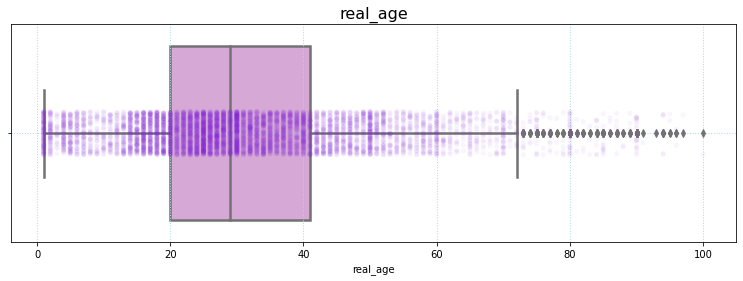

In [23]:
boxplot_5(data['real_age'], tit='real_age')

Фотографии людей возраста от 75 лет - редкие.

In [24]:
children = (data[data['real_age'] < 10]).sample(10, random_state=10).reset_index()
old = (data[data['real_age'] > 85]).sample(10, random_state=10).reset_index()
random_15 = data.sample(15, random_state=10).reset_index()

In [25]:
print('Количество фото детей до 10 лет -', (data[data['real_age'] < 10]['real_age']).count())
print('Количество фото пожилых людей после 85 лет -', (data[data['real_age'] > 85]['real_age']).count())

Количество фото детей до 10 лет - 663
Количество фото пожилых людей после 85 лет - 50


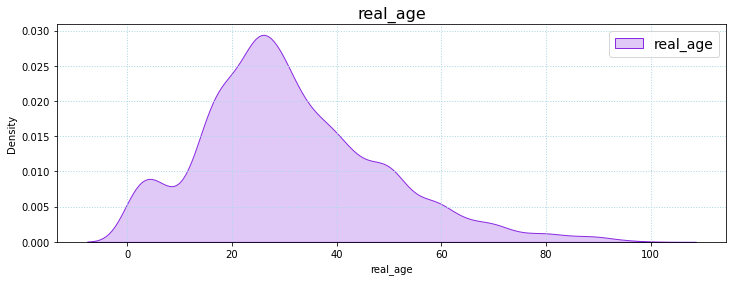

In [26]:
kde_one(data['real_age'], lab='real_age')

На графике распредления виден пик в районе 30 лет - среднего возраста датасета. Так же, наблюдается небольшой пик в районе 5 лет. Фотографий людей после 80 значительно меньше. Это может повлиять на работу модели - возраст пожилых покупаталей будет предсказыватся хуже.

In [27]:
# функция для вывода на экран фотографий в s строках и количестве f на строке
def photo(num_photo=data['file_name'], real_age=data['real_age'], s=1, f=5, figs=(20, 5)):
    
    fig, axes = plt.subplots(s, f, figsize=figs)
    
    count = -1
    
    if s == 1:
        
        for i in range(f):
            
            image = Image.open('/datasets/faces/final_files/' + num_photo[i])
            axes[i].imshow(np.array(image))
            axes[i].set_title('Real_year - ' + str(real_age[i]), fontsize=16)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
    else:
        
        for i in range(s):
        
            for j in range(f):

                count += 1

                image = Image.open('/datasets/faces/final_files/' + num_photo[count])
                axes[i, j].imshow(np.array(image))
                axes[i, j].set_title('Real_year - ' + str(real_age[count]), fontsize=16)
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])

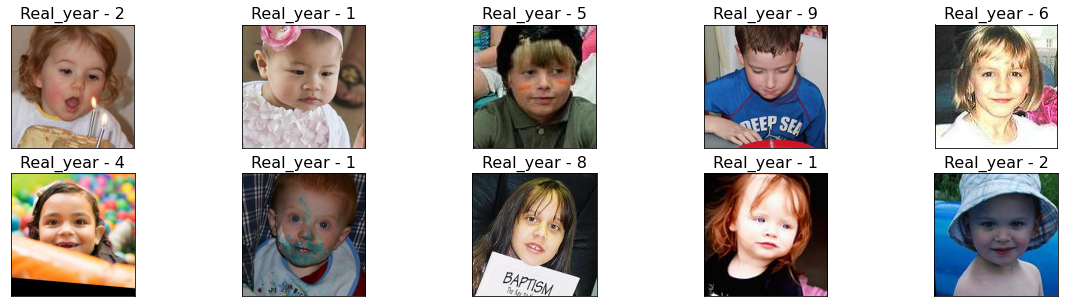

In [28]:
photo(num_photo=children['file_name'], real_age=children['real_age'], s=2)

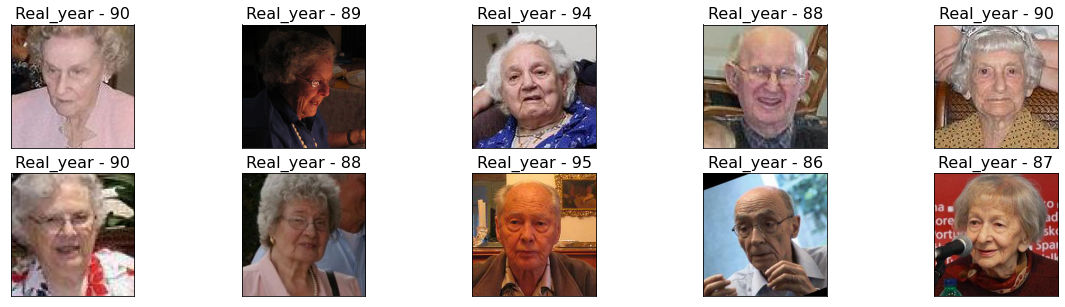

In [29]:
photo(num_photo=old['file_name'], real_age=old['real_age'], s=2)

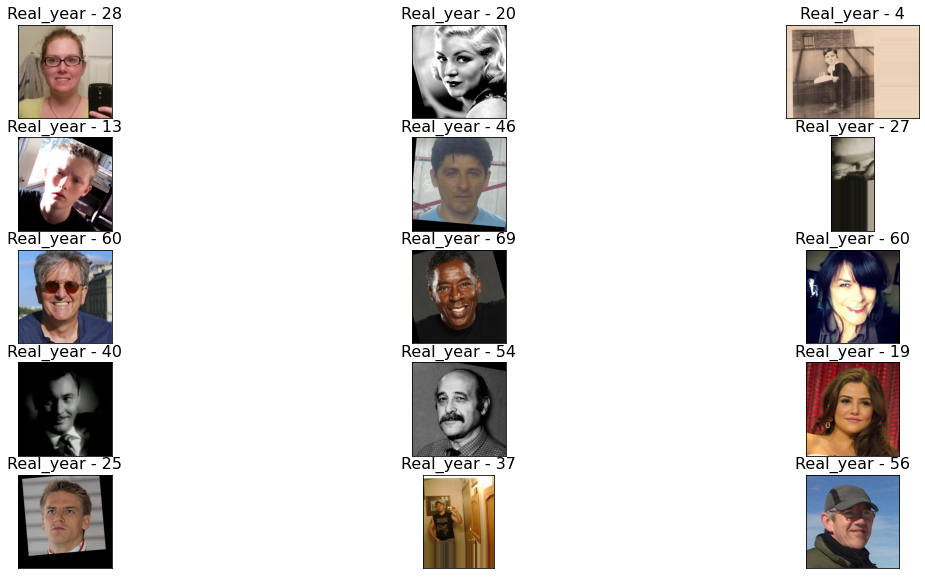

In [30]:
photo(num_photo=random_15['file_name'], real_age=random_15['real_age'], s=5, f=3, figs=(20, 10))

В датасете имеются фотографии людей различных возрастов от 1 до 100.  
Фотографии представлены в разных ракурсах, а так же со смещением и поворотом и различных цветовых гаммах: как черно-белые так и цветные. Тон, фон и шум так же различный, на некоторых фото присуствуют объекты не относящиеся к человеку, например, микрофон. 

**Вывод**
***  

- Датасет состоит из 7591 фотографии и таргета - возраста покупателя. Пропущенных значений и дубликатов не имеется;  
- Средний возраст людей на фото - 31 год, медианный - 29 лет; 
- Диапазон возрастов людей на фото от 1 до 100 лет. Стоит заметить, что фото с людьми вораста от 75 лет и выше - это редкие значеня;  
- Фотографии различные: от качетсва до тона. Присутствуют как цветные, так и черно-белые фотографии, со смещением и без, а так же, как лица крупным планом, так и более отдаленные фото;  
- Вероятно модель хуже будет определять возраст людей на фото от 85 лет, так как в датасете их всего 50 их 7591 фото. Так же, сложнее определить возраст на фото, где человек отдален или лицо засвечено или качество фото не очень хорошее; 
- Предстоит построить модель для решения задачи регрессии - определения возраста клиента.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



def load_train(path):
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255., 
                                       horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'), 
                                                     directory=(path + '/final_files'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(150, 150),
                                                     batch_size=16, 
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=5)


    return train_datagen_flow


def load_test(path):
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255.)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'), 
                                                     directory=(path + '/final_files'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(150, 150),
                                                     batch_size=16, 
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=5)


    return test_datagen_flow



def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()  

    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=.0001)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model 


def train_model(model, train_data, test_data, epochs=20, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        
        steps_per_epoch=len(train_data)
        
    if validation_steps is None:
        
        validation_steps=len(test_data)
        
    model.fit(train_data, validation_data=(test_data), epochs=epochs, verbose=2,
              batch_size=batch_size, validation_steps=validation_steps, 
              steps_per_epoch=steps_per_epoch)

    return model 

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-06-24 17:26:53.985441: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-24 17:26:54.295256: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 226.7477 - mae: 11.0071 - val_loss: 594.4201 - val_mae: 19.2993
Epoch 2/20
356/356 - 37s - loss: 93.0216 - mae: 7.3037 - val_loss: 144.8404 - val_mae: 9.4078
Epoch 3/20
356/356 - 37s - loss: 62.7063 - mae: 6.0410 - val_loss: 80.7194 - val_mae: 6.6975
Epoch 4/20
356/356 - 37s - loss: 45.3804 - mae: 5.1651 - val_loss: 93.6584 - val_mae: 7.1404
Epoch 5/20
356/356 - 37s - loss: 34.3396 - mae: 4.4919 - val_loss: 77.5463 - val_mae: 6.5806
Epoch 6/20
356/356 - 37s - loss: 27.0630 - mae: 3.9528 - val_loss: 78.5214 - val_mae: 6.6780
Epoch 7/20
356/356 - 37s - loss: 20.6943 - mae: 3.4532 - val_loss: 75.3702 - val_mae: 6.4490
Epoch 8/20
356/356 - 37s - loss: 17.6571 - mae: 3.2087 - val_loss: 74.8143 - val_mae: 6.6301
Epoch 9/20
356/356 - 37s - loss: 15.5085 - mae: 2.9636 - val_loss: 83.7168 - val_mae: 6.8564
Epoch 10/20
356/356 - 37s - loss: 12.8708 - mae: 2.7222 - val_loss: 70.1520 - val_mae: 6.2011
Epoch 11/20
356/356 - 37s - loss: 11.6323 - mae: 2.5865 - val_loss: 69.5249 - val_mae: 6.2299
Epoch 12/20
356/356 - 37s - loss: 12.8738 - mae: 2.6929 - val_loss: 74.3638 - val_mae: 6.4455
Epoch 13/20
356/356 - 37s - loss: 12.9576 - mae: 2.7141 - val_loss: 70.1833 - val_mae: 6.2717
Epoch 14/20
356/356 - 37s - loss: 12.3594 - mae: 2.6679 - val_loss: 66.8140 - val_mae: 6.1858
Epoch 15/20
356/356 - 37s - loss: 11.2854 - mae: 2.5475 - val_loss: 76.6814 - val_mae: 6.7943
Epoch 16/20
356/356 - 37s - loss: 10.8033 - mae: 2.4951 - val_loss: 71.7193 - val_mae: 6.4257
Epoch 17/20
356/356 - 37s - loss: 10.4103 - mae: 2.4324 - val_loss: 71.6692 - val_mae: 6.4760
Epoch 18/20
356/356 - 37s - loss: 9.8060 - mae: 2.3662 - val_loss: 78.1936 - val_mae: 6.7980
Epoch 19/20
356/356 - 37s - loss: 9.2574 - mae: 2.3105 - val_loss: 73.0959 - val_mae: 6.3655
Epoch 20/20
356/356 - 37s - loss: 9.5731 - mae: 2.3435 - val_loss: 74.5326 - val_mae: 6.2922
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 74.5326 - mae: 6.2922
Test MAE: 6.2922


```

## Анализ обученной модели

- использована модель ResNet50, с добавленным полносвязным слоем с 1 нейроном и активацией relu. Применен алгоритм оптимизации Adam со скоростью обучения lr=0,001 и аугментация - горизонтальный поворот;
- модель с функций потерь MSE, метрика качества - MAE;
- модель обучена на 20 эпохах, значение MAE ниже 8 на тестовой выборке получено на 3 эпохе и далее. После 5 эпохи значение MAE сильно не снижается и находится в диапазаоне от 6.18 до 6.8;
- большая разница между MAE на тренровочной и тестовой выборках - почти на всех эпохах около 4 пунктов;
- ***достигнуто значение MAE < 8 на тестовой выборке - 6.3.***
- для улучшения предсказания тренировочная выборка должна состоять из фото всех возрастов людей, и особенно тех возрастов, которые являются покупателями магазина;
- выборка должна быть равномерной по всем возрастам, для того, чтобы модель определяла любой возраст корректнее;
- исходные данные для обучения должны быть приближены к тем, которые возможно будет получить при применении нейросети в реальности: тон, цвет, качество фото. А так же, желательно, без лишних предметов;

## Вывод

- Исходный датасет состоит из 7591 фото, со средним возрастом 29 лет и медианным 31 год. Диапазон возрастов от 1 до 100. Значительно меньше в датасете фото людей до 10 лет и после 75 лет - их модель может определять некорректно.


- Для предсказания возраста по фотографиям была спользована архитектура нейронной сети ResNet50 с дополнительным полносвзяным слоем. Для оптимизации был применен алгорит Adam со скоростью обучения lr=0.001, а так же, применена аугментация - горизонтальный поворот. 


- Абсолютная ошибка составила на тестовой выборке 6.3 года: это не критично, в случае предложения товаров для покупателей магазина, так как, в возрасте +/- 6 лет, в основном, люди покупают примерно одни товары. При этом, полученная ошибка может быть  критичной в случае продажи алкоголя: например, модель может определить возраст 12 летнего человека как 18 летнего, что ненадежно.  


- Возможно улучшить исходную выборку для обучения и тем самым снизить MAE, например: 

    - сделать распределение возрастов более плавным, добавить фото людей тех, возрастов, которых недостаточно в датасете
    
    - или получить фото приближенные к тем, которые будут использоваться в реальности в магазине.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x] Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы